In [48]:
# Imports for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [49]:
# Loading data w/ encoding fix

df = pd.read_csv('../data/raw/startups_data.csv', encoding='latin-1')

## Initial Early Data Overview

**Dataset Size**: 54,294 startups w/ 39 features

**Key Features Confirmed**
- Geographic: country_code, region, city
- Industry: category_list, market
- Funding: funding_total_usd, funding rounds (A-H), funding types
- Temporal: founded_year`, funding dates
- Target: status (acquired/operating/closed)

In [50]:
# Some brief early exploration - rows, columns, column names, first 5 rows 

print(f"Dataset Shape: {df.shape}")
print(f"Columns {df.columns.tolist()}")
print(df.head())


Dataset Shape: (54294, 39)
Columns ['permalink', 'name', 'homepage_url', 'category_list', ' market ', ' funding_total_usd ', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
                         permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         

### Data Summary
- **Memory usage**: 16.2 MB - manageable for analysis
- **Critical issue**: funding_total_usd stored as text (object). Needs numeric conversion
- **Missing values**: Temporal features (~29% missing) and geographic data (~18% missing) require strategic handling
- **Good coverage**: Funding rounds and investment types have good completeness (91% non-null)

In [51]:
# Data types, memory usage, amount of non-null values per column

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [52]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Quality Assessment

### Key Findings

#### Missing Data Patterns
- **Geographic data**: Moderate missing values (18-20% for country/region, 44% for state_code)
- **Temporal data**: Significant gaps (~29% missing founding dates). Could impact our economic cycle analysis
- **Industry data**: Good coverage (16% missing for categories/market)
- **Critical insight**: Missing data appears systematic rather than random. Suggests data collection challenges for certain startup characteristics

#### Duplicate Analysis
- **4,943 duplicate company names** detected (9.1% of total dataset)
- Duplication investigation needed

#### Data Type Assessment
- **23 numeric features** (float64) - quantitative analysis
- **16 text features** (object) - categorical and funding data that needs cleaning
- **Key issue**: Funding amounts stored as text instead of numeric values

### Implications for ML Pipeline

**Strengths:**
- Large dataset size (54,294 companies)
- Rich feature set across geographic, temporal, and funding
- Sufficient data completeness for most critical features

**Preprocessing Requirements:**
1. **Missing value strategy** - especially for temporal features needed for bias-free methodology
2. **Duplicate investigation** - determine if these are truly separate entities
3. **Data type conversion** - clean funding amounts and other numeric features
4. **Feature engineering** - create geographic density and temporal cycle features

Early Data Quality Assessment

Top 10 Columns with Most Missing Values:
             Column  Missing_Count  Missing_Percentage
8        state_code          24133           44.448742
14  founded_quarter          15812           29.122923
13    founded_month          15812           29.122923
15     founded_year          15812           29.122923
12       founded_at          15740           28.990312
10             city          10972           20.208494
9            region          10129           18.655837
7      country_code          10129           18.655837
4           market            8824           16.252256
3     category_list           8817           16.239363
Duplicate company names: 4943
Data Types Summary:
float64    23
object     16
Name: count, dtype: int64


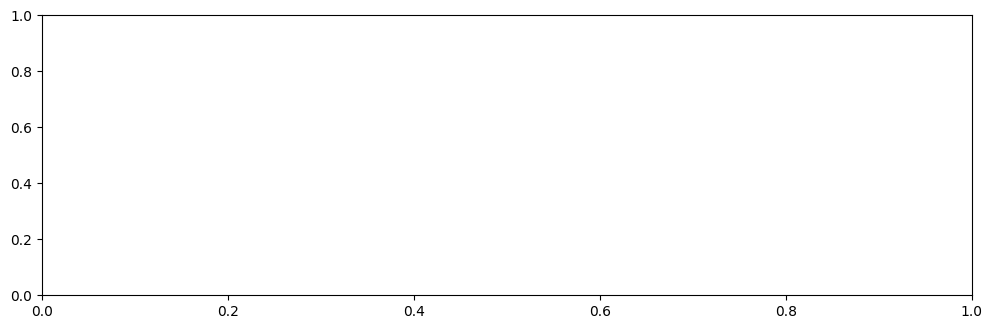

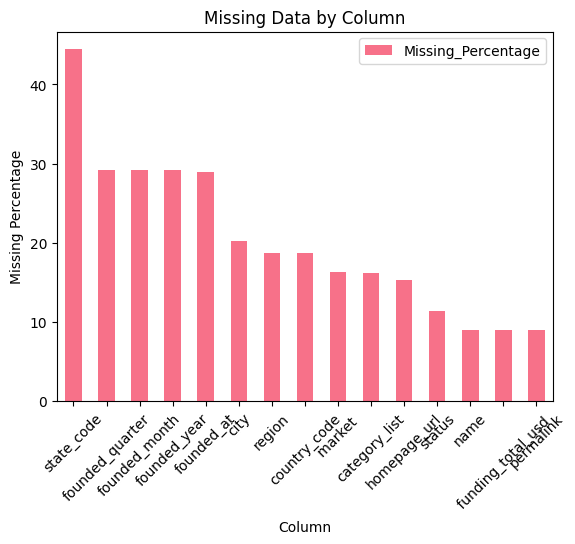

In [53]:
# Early Data Quality Assessment 

print("Early Data Quality Assessment")

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

print("\nTop 10 Columns with Most Missing Values:")
print(missing_df.head(10))

# Visualize missing data pattern

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
missing_df.head(15).plot(x='Column', y='Missing_Percentage', kind='bar')
plt.title('Missing Data by Column')
plt.xticks(rotation=45)
plt.ylabel('Missing Percentage')

# Checking for duplicate companies

duplicates = df.duplicated(subset=['name']).sum()
print(f"Duplicate company names: {duplicates}")

# Data type issues

print(f"Data Types Summary:")
print(df.dtypes.value_counts())


### Duplicate Investigation Results
The analysis reveals that "duplicate" company names are actually **separate companies** 
with the same name, evidenced by:
- Different founding years (2010, 2012, 2013)  
- Different funding amounts ($1M to $26.6M)
- Different business outcomes (acquired vs operating)

**Decision**: Keep all entries as they represent legitimate separate entities

In [54]:
# Duplicate Company Investigation

# Some duplicate examples

duplicate_names = df[df.duplicated(subset=['name'], keep=False)]['name'].value_counts().head(10)
print("Most frequent duplicate company names:")
print(duplicate_names)

# Checking if duplicates have different data respectively

sample_duplicate = duplicate_names.index[0]
duplicate_rows = df[df['name'] == sample_duplicate]
print(f"\nExample: All rows for '{sample_duplicate}':")
print(duplicate_rows[['name', 'status', 'founded_year', ' funding_total_usd ', 'country_code']].head())

Most frequent duplicate company names:
name
Spire                4
Roost                4
Hubbub               3
Compass              3
Cue                  3
Peach                3
Roadmap              3
Shift                3
AYOXXA Biosystems    2
Blink                2
Name: count, dtype: int64

Example: All rows for 'Spire':
        name     status  founded_year  funding_total_usd  country_code
40070  Spire   acquired           NaN          90,00,000           USA
40071  Spire  operating        2010.0          12,50,000           USA
40072  Spire  operating        2013.0           1,00,000           USA
40073  Spire  operating        2012.0        2,66,00,000           USA
